### Make all figures in the paper

In [1]:
# interactive figure
%matplotlib widget

In [2]:
# auto reload modules
%load_ext autoreload
%autoreload 2

import warnings
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcl
from sys import platform
from scipy import interpolate
from viztool import FormatScalarFormatter
from spectrum import Gaussian_filter_2d

In [3]:
def get_heps_ufunc(eps, z, criteria=1e-8):
    f = interpolate.interp1d(eps, z, assume_sorted=False)
    if max(eps) < criteria:
        heps = -z[-1]
    else:
        heps = -f(criteria)
    return heps

def get_aheps(ds, dims='zC'):
    heps = xr.apply_ufunc(get_heps_ufunc, ds.eps, ds[dims],
                          input_core_dims=[[dims], [dims]],
                          output_core_dims=[[]],
                          output_dtypes=[float],
                          kwargs=dict(criteria=1e-8),
                          dask='parallelized',
                          vectorize=True)
    mheps = heps.mean()
    aheps = (heps - mheps)/mheps
    return aheps

In [4]:
if platform == 'linux' or platform == 'linux2':
    data_dir = '/glade/derecho/scratch/zhihuaz/FrontalZone/Output/'
elif platform == 'darwin':
    data_dir = '/Users/zhihua/Documents/Work/Research/Projects/TRACE-SEAS/FrontalZone/Data/'
else:
    print('OS not supported.')

ds = []
dsf = []
cnames = ['s11_M036_Q000_W037_D270_St0',
          's11_M003_Q000_W444_D270_St0',
          's11_M009_Q000_W148_D000_St0',
          's11_M009_Q000_W148_D180_St0',
          's11_M009_Q000_W148_D090_St0',
          's11_M009_Q135_W148_D090_St0',
          # 's11_M036_Q200_W037_D090_St0',
         ]
for cname in cnames:
    tmp = xr.open_dataset(data_dir+cname+'_KE_budgets.nc')
    tmp.close()
    ds.append(tmp)

    # itime_snapshot = 295 #262
    # tmpf = xr.open_dataset(data_dir+cname+'_full.nc').isel(time=itime_snapshot)#.chunk({'zC':16})
    # tmpf.close()
    # tmpf['aheps'] = get_aheps(tmpf)
    # dsf.append(tmpf)

#### 3D snaphost

In [5]:
from mpl_toolkits.mplot3d.axis3d import Axis
if not hasattr(Axis, '_get_coord_info_old'):
    def _get_coord_info_new(self, renderer):
        mins, maxs, centers, deltas, tc, highs = self._get_coord_info_old(renderer)
        mins += deltas / 4
        maxs -= deltas / 4
        return mins, maxs, centers, deltas, tc, highs
    Axis._get_coord_info_old = Axis._get_coord_info
    Axis._get_coord_info = _get_coord_info_new

def plot_box_frame(ax, xmin, xmax, ymin, ymax, zmin, zmax, cloud=False, **edges_kw):
    ax.plot([xmax, xmax], [ymin, ymax], zmax, **edges_kw)
    ax.plot([xmin, xmax], [ymin, ymin], zmax, **edges_kw)
    ax.plot([xmin, xmin], [ymin, ymax], zmax, **edges_kw)
    ax.plot([xmin, xmax], [ymax, ymax], zmax, **edges_kw)
    ax.plot([xmax, xmax], [ymax, ymax], [zmin, zmax], **edges_kw)
    ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
    ax.plot([xmin, xmin], [ymin, ymin], [zmin, zmax], **edges_kw)
    if not cloud:
        ax.plot([xmax, xmax], [ymin, ymax], zmin, **edges_kw)
        ax.plot([xmin, xmax], [ymin, ymin], zmin, **edges_kw)
    else:
        ax.plot([xmin, xmin], [ymax, ymax], [zmin, zmax], **edges_kw)

# @wrap_matplotlib()
def plot_xyz3d(ax, ds, **kwargs):
    depth_lim = kwargs.pop('depth_lim')
    sub_str   = kwargs.pop('sub_str')
    blines    = kwargs.pop('blines')
    var       = kwargs.pop('var', 'b')

    ustar = np.sqrt(ds.attrs['τ₀']/ds.attrs['ρ₀'])
    xvar, yvar, zvar = sorted(ds[var].dims)
    xb, yb, zb = sorted(ds.b.dims)

    top   = ds[varsel].sel({zvar: -depth_lim[0], zb: -depth_lim[0]}, method='nearest')
    south = ds[varsel].isel({yvar: 0, yb: 0,}).sel({zvar: slice(-depth_lim[1],top[zvar]), zb: slice(-depth_lim[1],top[zb])})
    east  = ds[varsel].isel({xvar: -1, xb: -1}).sel({zvar: slice(-depth_lim[1],top[zvar]), zb: slice(-depth_lim[1],top[zb])})
    top['b']   = top.b   - ds.attrs['M²']*top[xb]
    south['b'] = south.b - ds.attrs['M²']*south[xb]
    east['b']  = east.b  - ds.attrs['M²']*east[xb]
    if var in ['u', 'v', 'w']:
        top[var]   = top[var]/ustar
        south[var] = south[var]/ustar
        east[var]  = east[var]/ustar

    xmin, xmax = np.around(south[xvar].min().data), np.around(south[xvar].max().data)
    ymin, ymax = np.around(east[yvar].min().data), np.around(east[yvar].max().data)
    zmin, zmax = np.around(east[zvar].min().data), np.around(top[zvar].data)
    Lx = xmax - xmin
    Lz = zmax - zmin
    ry = 1.22
    rz = 3.92
    zcloud = 52

    bkw = dict(levels=blines, linewidths=0, colors='xkcd:almost black')
    edges_kw = dict(color='xkcd:charcoal', linewidth=1, zorder=2)

    im = ax.contourf(top[xvar], top[yvar], top[var], zdir='z', offset=top[zvar], **kwargs)
    # ax.contour(top[xb], top[yb], top.b, zdir='z', offset=top[zb], **bkw)
    ax.contourf(ds.xC, ds.yC, ds.aheps, zdir='z', offset=zcloud, cmap='PRGn_r', extend='both',
                vmin=-0.7, vmax=0.7, levels=np.arange(-0.7, 0.8, 0.1), zorder=2)

    bkw.update(linewidths=0.2, colors='xkcd:almost black') #in place
    X, Z = np.meshgrid(south[xvar], south[zvar])
    ax.contourf(X, south[var], Z, zdir='y', offset=south[yvar], **kwargs)
    X, Z = np.meshgrid(south[xb], south[zb])
    ax.contour(X, south.b, Z, zdir='y', offset=south[yb], **bkw)

    Y, Z = np.meshgrid(east[yvar], east[zvar])
    ax.contourf(east[var], Y, Z, zdir='x', offset=east[xvar], **kwargs)
    Y, Z = np.meshgrid(east[yb], east[zb])
    ax.contour(east.b, Y, Z, zdir='x', offset=east[xb], **bkw)

    ax.axis('off')
    ax.set(xlim=[xmin, xmax],
           ylim=[ymin, ymax],
           zlim=[zmin, zmax])
    plot_box_frame(ax, xmin, xmax, ymin, ymax, zmin, zmax, **edges_kw)
    edges_kw.update(linestyle=':', linewidth=0.8, zorder=1)
    plot_box_frame(ax, xmin, xmax, ymin, ymax, zmax, zcloud, cloud=True, **edges_kw)
    
    ax.text2D(0.06, 0.36, sub_str, fontsize=12, ha='left', va='bottom', transform=ax.transAxes)
    ax.set_box_aspect((1, ymax/Lx*ry, Lz/Lx*rz))
    return im

##### boundary layer depth $h_{eps}(x,y)$ from dissipation

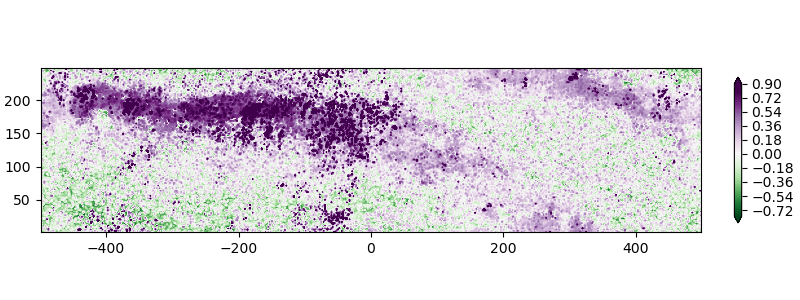

In [355]:
plt.close()
plt.figure(figsize=(8,3), constrained_layout=True)
i = 3

# faheps = Gaussian_filter_2d(dsf[i].aheps, 10, 'xy')
plt.contourf(dsf[i].xC, dsf[i].yC, dsf[i].aheps, cmap='PRGn_r',
             vmin=-0.8, vmax=0.8, levels=np.arange(-0.8, 0.9, 0.1), extend='both')
plt.colorbar(shrink=0.5)
plt.gca().set_aspect('equal');

##### along-front velocity $v$

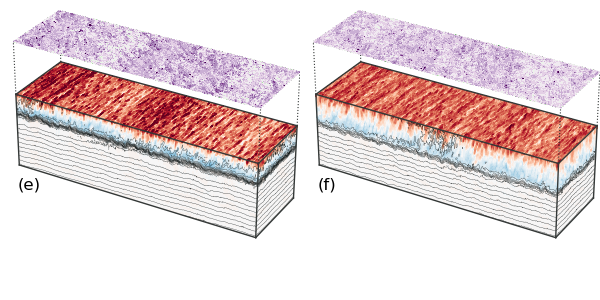

In [352]:
plt.close()
nrow, ncol = 1, 2
subplot_kw = dict(projection='3d', computed_zorder=False)
fig, ax = plt.subplots(nrow, ncol, figsize=(6,3), subplot_kw=subplot_kw)
plt.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, right=1, left=0)

var = 'v'
varsel = [var, 'b']
letter = 'abcdef'
vmin, vmax = -9, 9
depth_lim = [3, 80]
plt_kwargs = dict(var=var, cmap='RdBu_r', vmin=vmin, vmax=vmax, blines=np.arange(0, 2.6, 0.008)*1e-2,
                  levels=np.linspace(vmin, vmax, 64), depth_lim=depth_lim, extend='both')

for i in range(len(dsf)):
    plt_kwargs.update(sub_str=f'({letter[i]})')
    ir, ic = np.unravel_index(i, (3,2))
    im = plot_xyz3d(ax[ic], dsf[i], **plt_kwargs);
    if ic==1:
        plt.savefig(f'../Figures/all_3Dsnapshot_v{ir+1}', dpi=600, bbox_inches='tight', pad_inches=0);
    if ir!=2 and ic==1:
        [ax[k].cla() for k in range(ncol)];

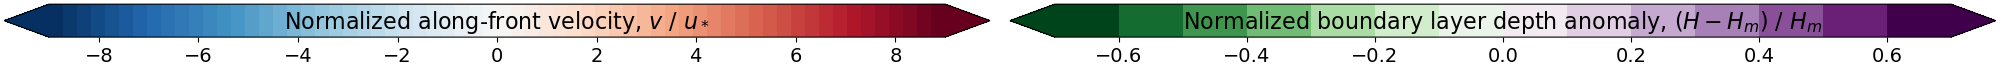

In [353]:
plt.close()
fig,ax = plt.subplots(1,2, figsize=(20,0.7), constrained_layout=True)

cmap0 = mpl.cm.RdBu_r.resampled(64)
norm0 = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cbar0 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm0, cmap=cmap0), extend='both',
                    cax=ax[0], aspect=20, orientation='horizontal')
cbar0.set_label(r'Normalized along-front velocity, $v$ / $u_*$', labelpad=-41, fontsize=16)
cbar0.ax.tick_params(labelsize=14)

cmap1 = mpl.cm.PRGn_r.resampled(14)
norm1 = mpl.colors.Normalize(vmin=-0.7, vmax=0.7)
cbar1 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm1, cmap=cmap1), extend='both',
                    cax=ax[1], aspect=20, orientation='horizontal')
cbar1.set_label(r'Normalized boundary layer depth anomaly, $(H-H_m)$ / $H_m$', labelpad=-41, fontsize=16)
cbar1.ax.tick_params(labelsize=14);

plt.savefig('../Figures/all_3Dsnapshot_v4', dpi=600);

##### cross-front velocity $u$

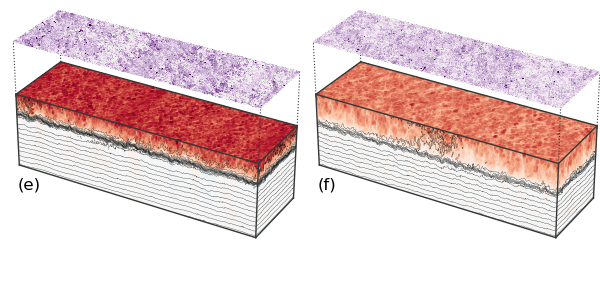

In [364]:
plt.close()
nrow, ncol = 1, 2
subplot_kw = dict(projection='3d', computed_zorder=False)
fig, ax = plt.subplots(nrow, ncol, figsize=(6,3), subplot_kw=subplot_kw)
plt.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, right=1, left=0)

var = 'u'
varsel = [var, 'b']
letter = 'abcdef'
vmin, vmax = -12, 12
depth_lim = [3, 80]
plt_kwargs = dict(var=var, cmap='RdBu_r', vmin=vmin, vmax=vmax, blines=np.arange(0, 2.6, 0.008)*1e-2,
                  levels=np.linspace(vmin, vmax, 64), depth_lim=depth_lim, extend='both')

for i in range(len(dsf))[-2:]:
    plt_kwargs.update(sub_str=f'({letter[i]})')
    ir, ic = np.unravel_index(i, (3,2))
    im = plot_xyz3d(ax[ic], dsf[i], **plt_kwargs);
    if ic==1:
        plt.savefig(f'../Figures/all_3Dsnapshot_{var}{ir+1}', dpi=600, bbox_inches='tight', pad_inches=0);
    # if ir!=2 and ic==1:
    #     [ax[k].cla() for k in range(ncol)];

In [386]:
dsf[4].aheps.quantile(0.96)

<xarray.DataArray 'aheps' ()> Size: 8B
array(0.29669851)
Coordinates:
    quantile  float64 8B 0.96

##### vertical velocity $w$

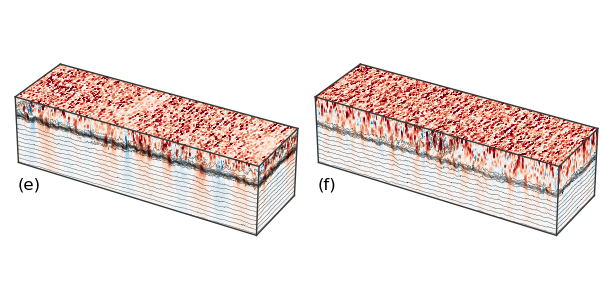

In [19]:
plt.close()
nrow, ncol = 1, 2
subplot_kw = dict(projection='3d', computed_zorder=False)
fig, ax = plt.subplots(nrow, ncol, figsize=(6,3), subplot_kw=subplot_kw)
plt.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, right=1, left=0)

var = 'w'
varsel = [var, 'b']
letter = 'abcdef'
vmin, vmax = -2, 2
depth_lim = [3, 80]
plt_kwargs = dict(var=var, cmap='RdBu_r', vmin=vmin, vmax=vmax, blines=np.arange(0, 2.6, 0.008)*1e-2,
                  levels=np.linspace(vmin, vmax, 64), depth_lim=depth_lim, extend='both')

for i in range(len(dsf)):
    plt_kwargs.update(sub_str=f'({letter[i]})')
    ir, ic = np.unravel_index(i, (3,2))
    im = plot_xyz3d(ax[ic], dsf[i], **plt_kwargs);
    if ic==1:
        plt.savefig(f'../Figures/all_3Dsnapshot_{var}{ir+1}', dpi=600, bbox_inches='tight', pad_inches=0);
    if ir!=2 and ic==1:
        [ax[k].cla() for k in range(ncol)];

##### potential vorticity $q$

In [194]:
dsf[0].q.quantile(0.03).load()

<xarray.DataArray 'q' ()> Size: 8B
array(-4.37580594e-08)
Coordinates:
    quantile  float64 8B 0.03

In [ ]:
# plt.close()
# nrow, ncol = 1, 2
# subplot_kw = dict(projection='3d', computed_zorder=False)
# fig, ax = plt.subplots(nrow, ncol, figsize=(6,3), subplot_kw=subplot_kw)
# plt.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, right=1, left=0)

# var = 'q'
# varsel = [var, 'b']
# letter = 'abcdef'
# vmin, vmax = -3e-10, 3e-10
# depth_lim = [3, 80]
# plt_kwargs = dict(var=var, cmap='RdBu_r', vmin=vmin, vmax=vmax, blines=np.arange(0, 2.6, 0.008)*1e-2,
#                   levels=np.linspace(vmin, vmax, 64), depth_lim=depth_lim, extend='both')

# for i in range(len(dsf))[:2]:
#     plt_kwargs.update(sub_str=f'({letter[i]})')
#     ir, ic = np.unravel_index(i, (3,2))
#     im = plot_xyz3d(ax[ic], dsf[i], **plt_kwargs);
#     if ic==1:
#         plt.savefig(f'../Figures/all_3Dsnapshot_{var}{ir+1}', dpi=600, bbox_inches='tight', pad_inches=0);
#     # if ir!=2 and ic==1:
#     #     [ax[k].cla() for k in range(ncol)];

#### Surface velocity evolution

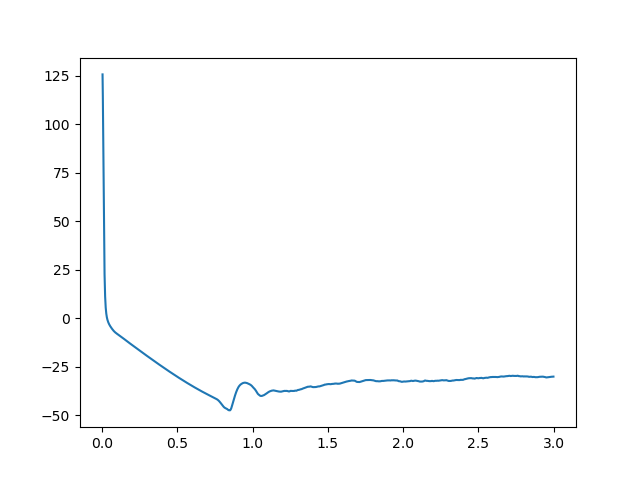

In [359]:
theta = np.arctan2(ds[2].v.isel(zC=-1), ds[2].u.isel(zC=-1)) * 180 / np.pi
plt.close()
plt.figure()

plt.plot(ds[2].timeTf, theta);

#### Dissipation rate

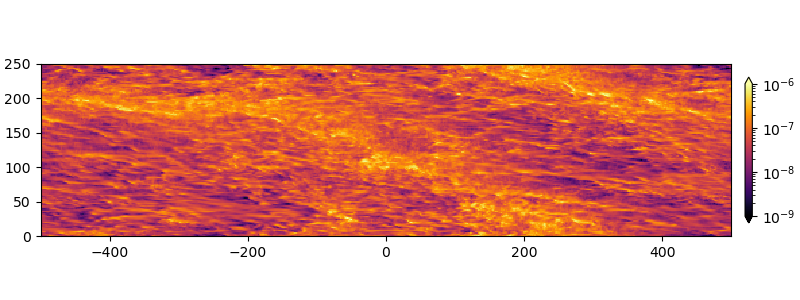

In [11]:
plt.close()
plt.figure(figsize=(8,3), constrained_layout=True)
pmkw = dict(cmap='inferno', norm=mcl.LogNorm(vmin=1e-9, vmax=1e-6))

i = 3
meps = dsf[i].eps.mean('zC')
pm = plt.pcolormesh(dsf[i].xC, dsf[i].yC, meps, **pmkw)
cbar = plt.colorbar(pm, pad=0.02, shrink=0.5, extend='both', location='right')
plt.gca().set_aspect('equal');

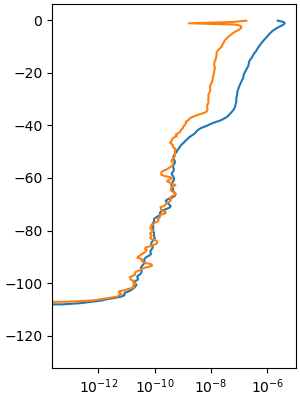

In [19]:
plt.close()
plt.figure(figsize=(3,4), constrained_layout=True)

plt.plot(dsf[i].eps.where(meps>=1e-7).mean(['xC','yC']), dsf[i].zC)
plt.plot(dsf[i].eps.where(meps<1e-8).mean(['xC','yC']), dsf[i].zC)
plt.xscale('log');

In [360]:
def plot_dissipation(ax, ds, **kwargs):
    bkw  = kwargs.pop('bkw')
    pmkw = kwargs.pop('pmkw')
    sub_str = kwargs.pop('sub_str')
    eps_scale = ds.ustar2**(3/2) / ds.bld
    pm = ax.pcolormesh(ds.timeTf, ds.zC, (ds.TKE_eps.clip(min=1e-16)/eps_scale).T, **pmkw)
    # ax.contour(ds.timeTf, ds.zC, ds.TKE_eps.T, [1e-8], colors='w', linestyles=':')
    ax.contour(ds.timeTf, ds.zC, ds.TKE_eps.T, [1e-9], colors='w')
    ax.contour(ds.timeTf, ds.zC, ds.b.T, np.arange(0,2.6,0.006)*1e-2, **bkw)
    ax.plot(ds.timeTf, -ds.bld, 'c')
    ax.text(0.03, 0.05, sub_str, fontsize=14, color='w', ha='left', va='bottom', transform=ax.transAxes)
    return pm

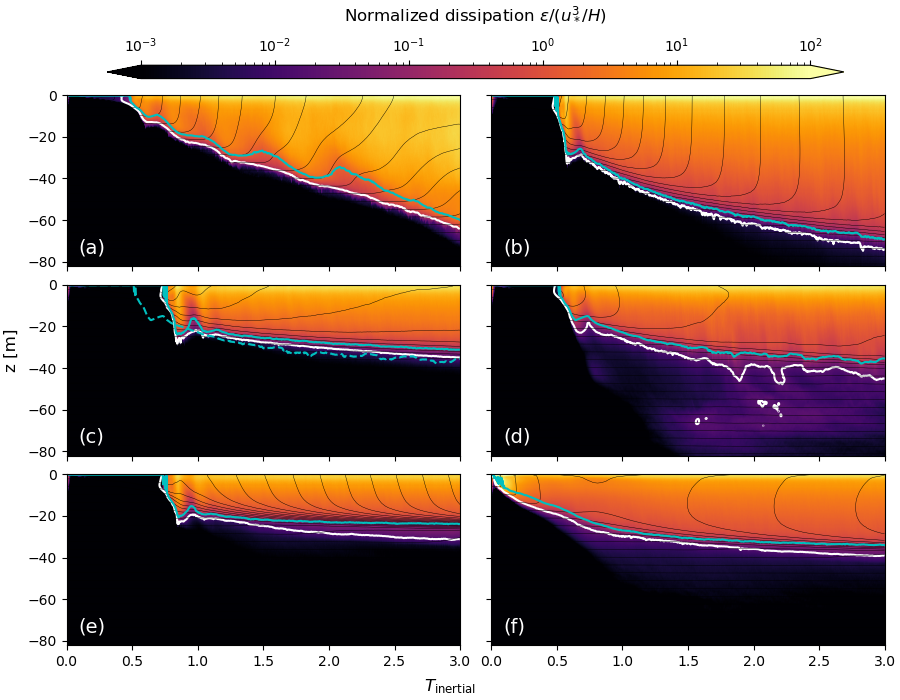

In [361]:
plt.close()
fig,ax = plt.subplots(3,2, figsize=(9,7), constrained_layout=True, sharex=True, sharey=True)

letters = 'abcdef'
bkw = dict(colors='k', linewidths=0.3)
pmkw = dict(cmap='inferno', norm=mcl.LogNorm(vmin=1e-3, vmax=1e2))

for i in range(len(ds)):
    ix, iy = np.unravel_index(i, ax.shape)
    pm = plot_dissipation(ax[ix,iy], ds[i], bkw=bkw, pmkw=pmkw, sub_str=f'({letter[i]})')
ax[1,0].plot(ds[3].timeTf, -ds[3].bld, '--c')

plt.ylim(-82,0)
plt.xlim(0,3)
cbar = fig.colorbar(pm, ax=ax, pad=0.02, shrink=0.9, fraction=0.05, aspect=55, extend='both', location='top')
cbar.set_label(r"Normalized dissipation $\epsilon / (u^3_*/H)$", labelpad=12, fontsize=12)
fig.supylabel('z [m]')
fig.supxlabel(r'$T_{\mathrm{inertial}}$');

# plt.savefig('../Figures/all_epsilon', dpi=600);

#### Turbulent kinetic energy (TKE)

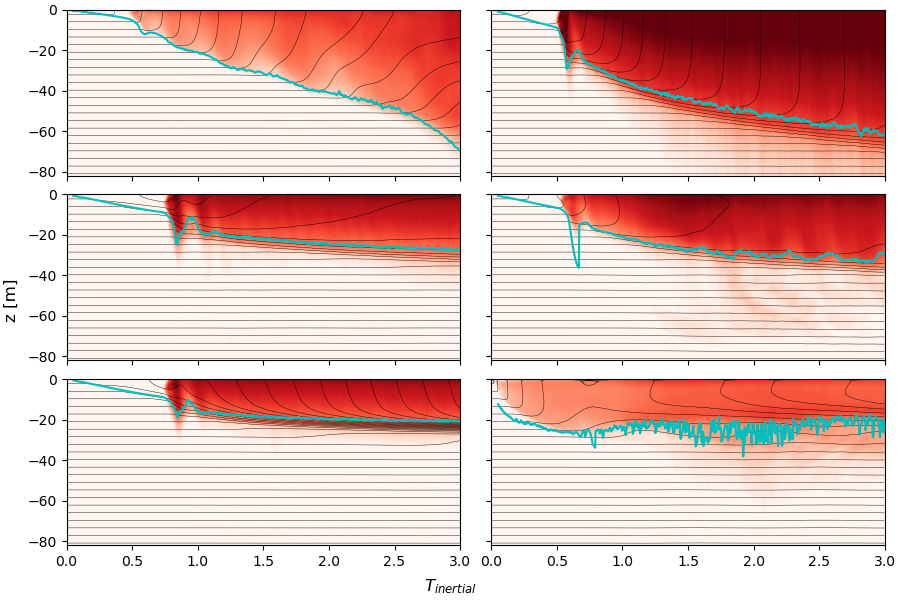

In [4]:
plt.close()
fig,ax = plt.subplots(3,2, figsize=(9,6), constrained_layout=True, sharex=True, sharey=True)

bkw = dict(colors='k', linewidths=0.3)
kw = dict(cmap='Reds', norm=mcl.LogNorm(vmin=1e-5, vmax=1e-3))

ax[0,0].pcolormesh(ds[0].timeTf, ds[0].zC, ds[0].TKE.T, **kw)
# cbar = plt.colorbar(pad=-0.0, extend='both')
ax[0,0].contour(ds[0].timeTf, ds[0].zC, ds[0].b.T, np.arange(0,2.6,0.006)*1e-2, **bkw)
ax[0,0].plot(ds[0].timeTf, -ds[0].bld, 'c')

ax[0,1].pcolormesh(ds[1].timeTf, ds[1].zC, ds[1].TKE.T, **kw)
ax[0,1].contour(ds[1].timeTf, ds[1].zC, ds[1].b.T, np.arange(0,2.6,0.006)*1e-2, **bkw)
ax[0,1].plot(ds[1].timeTf, -ds[1].bld, 'c')

ax[1,0].pcolormesh(ds[2].timeTf, ds[2].zC, ds[2].TKE.T, **kw)
ax[1,0].contour(ds[2].timeTf, ds[2].zC, ds[2].b.T, np.arange(0,2.6,0.006)*1e-2, **bkw)
ax[1,0].plot(ds[2].timeTf, -ds[2].bld, 'c')

ax[1,1].pcolormesh(ds[3].timeTf, ds[3].zC, ds[3].TKE.T, **kw)
ax[1,1].contour(ds[3].timeTf, ds[3].zC, ds[3].b.T, np.arange(0,2.6,0.006)*1e-2, **bkw)
ax[1,1].plot(ds[3].timeTf, -ds[3].bld, 'c')

ax[2,0].pcolormesh(ds[4].timeTf, ds[4].zC, ds[4].TKE.T, **kw)
ax[2,0].contour(ds[4].timeTf, ds[4].zC, ds[4].b.T, np.arange(0,2.6,0.006)*1e-2, **bkw)
ax[2,0].plot(ds[4].timeTf, -ds[4].bld, 'c')

ax[2,1].pcolormesh(ds[5].timeTf, ds[5].zC, ds[5].TKE.T, **kw)
ax[2,1].contour(ds[5].timeTf, ds[5].zC, ds[5].b.T, np.arange(0,2.6,0.006)*1e-2, **bkw)
ax[2,1].plot(ds[5].timeTf, -ds[5].bld, 'c')
plt.ylim(-82,0)
plt.xlim(0,3);

fig.supylabel('z [m]')
fig.supxlabel(r'$T_{inertial}$');

#### TKE budget

In [10]:
def plot_tke_budget(ax, ds, sub_str=None, main_ax=True):
    kw = dict(lw=1.5) if main_ax else dict(lw=1)
    time_interval = (ds.timeTf >= 2) & (ds.timeTf < 3)
    B0  = ds.Qb.where(time_interval).mean('time')
    EBF = ds.Qv.where(time_interval).mean('time')*ds.attrs['M²']/ds.f
    TBF = EBF + B0

    l2, = ax.plot(ds.ASP_sc, ds.sC, **kw)
    l3, = ax.plot(ds.GSP_sc, ds.sC, 'C2', **kw)
    l4, = ax.plot(ds.wbt_sc, ds.sC, 'C1', **kw)
    l6, = ax.plot(-(ds.TKE_tur_sc + ds.TKE_prs_sc + ds.TKE_vis_sc), ds.sC, 'xkcd:tan brown', lw=0.8)
    l7, = ax.plot(-ds.TKE_eps_sc, ds.sC, 'xkcd:cool grey', **kw)

    if main_ax:
        l5, = ax.plot(ds.GSP_sc + ds.wbt_sc, ds.sC, '--', c='xkcd:barney purple', **kw)
        l1, = ax.plot([TBF, 0], [0, -1], ':r', label='_nolegend_', **kw)
        s1  = ax.scatter(B0,  0, 20, 'C1', marker='o', edgecolor='gray', lw=0.5, clip_on=False, zorder=3)
        s2  = ax.scatter(EBF, 0, 20, 'C2', marker='o', edgecolor='gray', lw=0.5, clip_on=False, zorder=3)
        s3  = ax.scatter(TBF, 0, 20, 'r',  marker='o', edgecolor='gray', lw=0.5, clip_on=False, zorder=3)
        ax.text(0.03, 0.05, sub_str, fontsize=14, ha='left', va='bottom', transform=ax.transAxes)
        ax.grid('on', ls='--', lw=0.4)
        if EBF == 0:
            xabsm = np.abs(ds.Qu.where(time_interval).mean('time')*ds.attrs['M²']/ds.f)*2
        else:
            xabsm = np.abs(EBF)*2
        ax.set_xlim(-xabsm, xabsm)
        return [l2, l3, l4, l5, l1, l6, l7, s1, s2, s3]
    else:
        xabsm = np.concatenate([ds.ASP_sc, ds.TKE_eps_sc]).max()
        ax.set_xlim(-xabsm, xabsm)
        ax.set_ylim(-1.2,0)
        ax.patch.set_alpha(0.6)

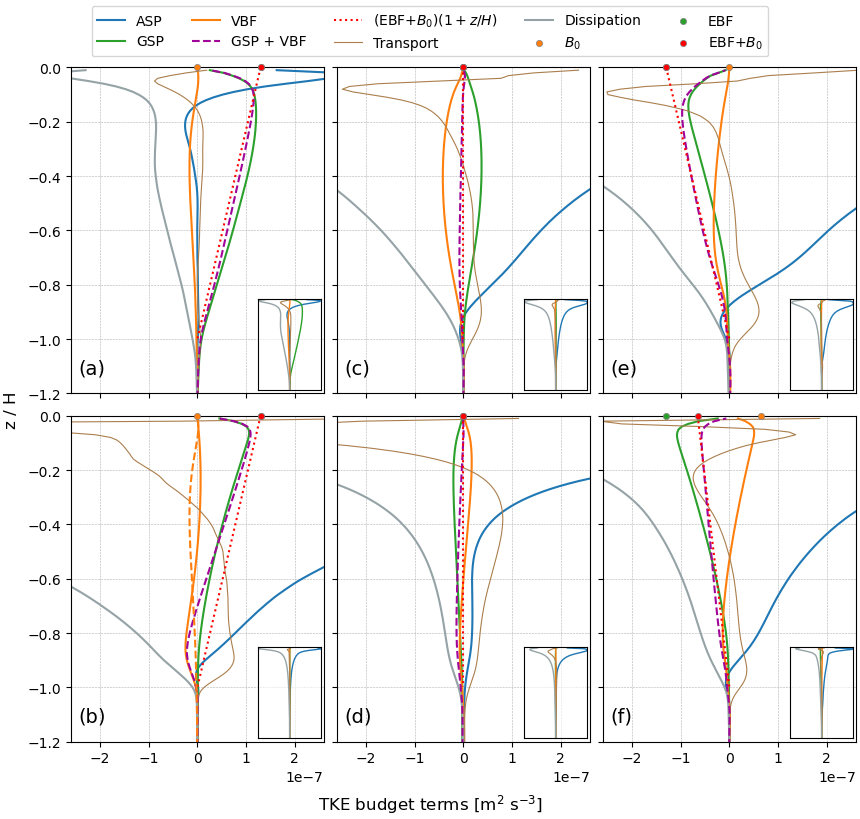

In [11]:
plt.close()
fig,ax = plt.subplots(2,3, figsize=(8.6,8.2), constrained_layout=True, sharey=True, sharex=True)
letters = 'abcdef'

for i in range(len(ds)):
    ix, iy = np.unravel_index(i, ax.shape, order='F')
    handles = plot_tke_budget(ax[ix,iy], ds[i], sub_str=f'({letters[i]})')
    
    axins = ax[ix,iy].inset_axes([0.74, 0.01, 0.25, 0.28],
                                 xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plot_tke_budget(axins, ds[i], main_ax=False)

# ax[1,0].plot(ds[0].wbt_sc, ds[0].sC, '--C1')
fig.legend(handles, ['ASP', 'GSP', 'VBF', 'GSP + VBF', r'(EBF+$B_0)(1+z/H)$',
                     'Transport', 'Dissipation', r'$B_0$', 'EBF', r'EBF+$B_0$'],
           loc='outside upper center', ncols=5)
plt.ylim(-1.2,0)
fig.supylabel('z / H')
fig.supxlabel(r'TKE budget terms [m$^2$ s$^{-3}$]');

# plt.savefig('../Figures/all_tke_budgets', dpi=600);

#### PV flux

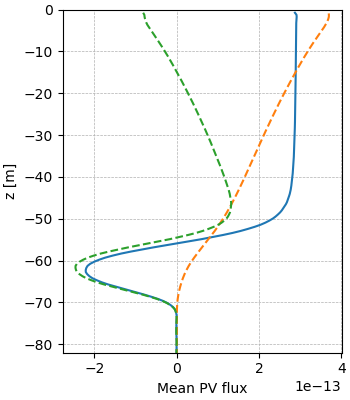

In [5]:
plt.close()
fig = plt.figure(figsize=(3.5,4), constrained_layout=True)

i = 1
time_interval = (ds[i].timeTf >= 2) & (ds[i].timeTf < 3)

plt.plot(-ds[i].f*ds[i].attrs['M²']*ds[i].u.where(time_interval).mean(['time'])[:-1] +
          ds[i].f*ds[i].dwbdz.where(time_interval).mean(['time'])[:-1], ds[i].zC[:-1])
plt.plot(-ds[i].f*ds[i].attrs['M²']*ds[i].u.where(time_interval).mean(['time'])[:-1], ds[i].zC[:-1], '--')
plt.plot( ds[i].f*ds[i].dwbdz.where(time_interval).mean(['time'])[:-1],               ds[i].zC[:-1], '--')
plt.grid('on', ls='--', lw=0.5)
plt.ylim(-82, 0)
# plt.xlim(-4e-9, 4e-9)
plt.ylabel('z [m]');
plt.xlabel('Mean PV flux');

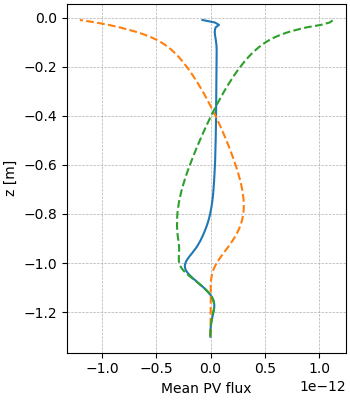

In [9]:
plt.close()
fig = plt.figure(figsize=(3.5,4), constrained_layout=True)

i = 2

plt.plot(-ds[i].f*ds[i].attrs['M²']*ds[i].u_sc + ds[i].f*ds[i].dwbdz_sc, ds[i].sC)
plt.plot(-ds[i].f*ds[i].attrs['M²']*ds[i].u_sc, ds[i].sC, '--')
plt.plot( ds[i].f*ds[i].dwbdz_sc,               ds[i].sC, '--')
plt.grid('on', ls='--', lw=0.5)
# plt.ylim(-82, 0)
# plt.xlim(-4e-9, 4e-9)
plt.ylabel('z [m]');
plt.xlabel('Mean PV flux');

#### Reynolds stress

In [ ]:
plt.close()
fig = plt.figure(figsize=(4,4.8), constrained_layout=True)
time_interval = (dsh.timeTf >= 2) & (dsh.timeTf < 3)
zdum = np.linspace(-1,0)
tau_Derbyshire = -(1+zdum)**(3/2 - np.sqrt(3)/2*1j)

p1, = plt.plot(-(dsh.wvt/dsh.ustar2).where(time_interval).mean(['time']), dsh.sigmaC.where(time_interval).mean(['time']), c='xkcd:ocean')
p2, = plt.plot(-(dsh.wut/dsh.ustar2).where(time_interval).mean(['time']), dsh.sigmaC.where(time_interval).mean(['time']), c='xkcd:cranberry')
p3, = plt.plot(-(dsh.wv/dsh.ustar2).where(time_interval).mean(['time']), dsh.sigmaC.where(time_interval).mean(['time']),
         'o', c='xkcd:ocean', markersize=3, mfc='none', lw=0.02)
p4, = plt.plot(-(dsh.wu/dsh.ustar2).where(time_interval).mean(['time']), dsh.sigmaC.where(time_interval).mean(['time']),
         'o', c='xkcd:cranberry',   markersize=3, mfc='none', lw=0.02)
p5, = plt.plot(-np.real(tau_Derbyshire), zdum, '--', c='xkcd:neon blue')
p6, = plt.plot(-np.imag(tau_Derbyshire), zdum, '--', c='xkcd:reddish orange')
p7, = plt.plot([0], marker='None', linestyle='None')
p8  = matplotlib.patches.Rectangle((0,0), 0, 0, color='w')
plt.legend([p8, p1, p3, p5, p7, p8, p2, p4, p6],
           [r'$\bf{Downwind}$',  'resolved', 'resolved + SGS', 'prediction', '',
            r'$\bf{Crosswind}$', 'resolved', 'resolved + SGS', 'prediction'], frameon=False)
plt.grid('on', ls='--', lw=0.5)
plt.ylim(-1.2, 0)
plt.xlim(-1,1)
plt.ylabel('z / H');
plt.xlabel(r"$-\overline{w'\bf{u}'}$ / $u_*^2$");

axins = plt.gca().inset_axes([0.04, 0, 0.42, 0.42],
                             xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axins.axvline(0, ls=':', c='gray')
axins.axhline(0, ls=':', c='gray')
axins.plot(-(dsh.wu/dsh.ustar2).where(time_interval).mean(['time']), 
           -(dsh.wv/dsh.ustar2).where(time_interval).mean(['time']), 'k', lw=2)
axins.plot(-np.imag(tau_Derbyshire), -np.real(tau_Derbyshire), '--k', lw=2)
axins.text(0.95, 0.45, 'x', ha='right', va='top', color='gray', transform=axins.transAxes, fontsize=8)
axins.text(0.45, 0.95, 'y', ha='right', va='top', color='gray', transform=axins.transAxes, fontsize=8)
axins.set_aspect('equal', 'box')
axins.patch.set_alpha(0.5)
axins.set_xlim(-1,1)
axins.set_ylim(-1,1);

# plt.savefig('../Figures/'+cname+'_stress_profile', dpi=600);
# plt.savefig('../Figures/'+cname+'_stress_profile.pdf', dpi=600, format='pdf')